In [1]:
from pylab import *

import skimage
from skimage import color
from skimage import exposure
from skimage import filters
from skimage import io

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import numpy as np


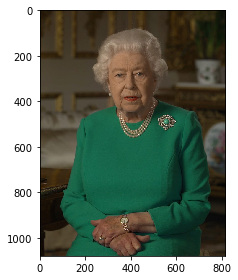

In [2]:
imgQueen = imread('queen_dress.jpg')

io.imshow(imgQueen)

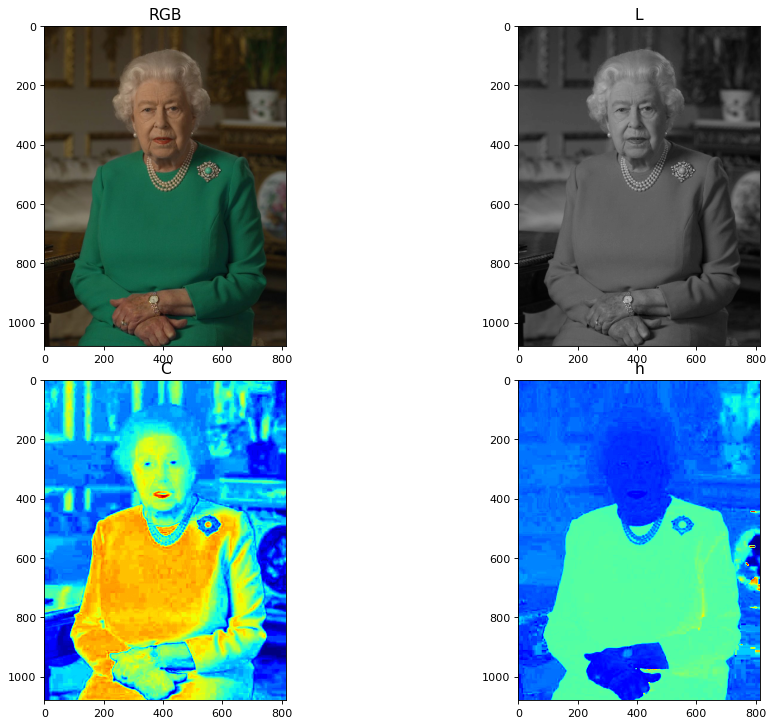

In [3]:
imgQueenLab = color.rgb2lab(imgQueen)

imgQueenLCh = color.lab2lch(imgQueenLab)

fig, ax = plt.subplots(2, 2, figsize=(12,9), dpi=80);
tight_layout();
ax[0,0].imshow(imgQueen); ax[0,0].set_title('RGB', fontsize=14);
ax[0,1].imshow(imgQueenLCh[:,:,0], vmin=np.min(imgQueenLCh[:,:,0]), vmax=np.max(imgQueenLCh[:,:,0]), cmap='gray'); ax[0,1].set_title('L', fontsize=14);
ax[1,0].imshow(imgQueenLCh[:,:,1], vmin=np.min(imgQueenLCh[:,:,1]), vmax=np.max(imgQueenLCh[:,:,1]), cmap='jet'); ax[1,0].set_title('C', fontsize=14);
ax[1,1].imshow(imgQueenLCh[:,:,2], vmin=0, vmax=2*pi, cmap='jet'); ax[1,1].set_title('h', fontsize=14);


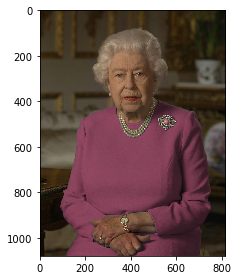

In [4]:
downTreshold = 3*pi/4
upTreshold = 5*pi/4
mask = (imgQueenLCh[:,:,2]>downTreshold) & (imgQueenLCh[:,:,2]<upTreshold)

imgQueenLCh[mask,2] = 0
imgQueenLab = color.lch2lab(imgQueenLCh)
imgQueen = color.lab2rgb(imgQueenLab)

io.imshow(imgQueen)